notes to improve on

regularisation
transforms
auto lr find
transfer learning?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from pathlib2 import Path
from PIL import Image
import torch
import math
import torch.nn as nn
from torchvision.transforms import transforms
from matplotlib import pyplot
import pandas as pd


The key

Paths

In [10]:
DATA_PATH = Path(os.getcwd()+"/data")
PATH = DATA_PATH/"kaggle"
TRAIN_PATH = PATH/"upsampled_images"
TEST_PATH = PATH/"Test/"

Select Devices

Import CSVs

In [3]:
sketch_df = pd.read_csv(PATH/'sketches_train.csv')

In [4]:
sketch_x = sketch_df.iloc[:,1:785]
sketch_x.head

<bound method NDFrame.head of       V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  ...  V775  V776  V777  V778  \
0      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
1      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
2      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
3      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
4      0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
5995   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
5996   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
5997   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
5998   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   
5999   0   0   0   0   0   0   0   0   0    0  ...     0     0     0     0   

      V779  V780  V781  V782  V78

In [5]:
sketch_y = sketch_df.iloc[:,785:786]
sketch_y.head

<bound method NDFrame.head of            word
0     boomerang
1     boomerang
2     boomerang
3     boomerang
4     boomerang
...         ...
5995     banana
5996     banana
5997     banana
5998     banana
5999     banana

[6000 rows x 1 columns]>

In [6]:
(sketch_x.to_numpy()[5]).shape

(784,)

In [26]:
#make images from array
i = 0
for row in sketch_x.to_numpy(): #get numpy array from pandas df 
    arr = row 
    i += 1
    sqr = arr.reshape(28,28).astype(np.uint8)
    img = Image.fromarray(sqr)
    img.save(str(TRAIN_PATH)+"/"+str(i)+".png", "PNG")

In [22]:
TRAIN_PATH

WindowsPath('C:/Users/georg/.fyp/data/kaggle/Train')

In [13]:
#organise images into class folders

shapeIDs = list(sketch_y['word'].unique())

#Run Once to make img
for s in shapeIDs:
    os.makedirs(str(TRAIN_PATH)+'/'+s)

for idx in sketch_y.index:
    image = str(idx+1)+'.png'
    folder = sketch_y.loc[idx, 'word']
    old = 'C:/Users/georg/.fyp/data/kaggle/upsampled_images/{}'.format(image)
    new = 'C:/Users/georg/.fyp/data/kaggle/upsampled_images/{}/{}'.format(folder, image)
    try:
        os.rename(old, new)
    except:
        print('{} - {}'.format(image,folder))

In [16]:
#try fastai method
from fastai.vision import *
np.random.seed(103078)
sketch_data = ImageDataBunch.from_folder(TRAIN_PATH, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=28, num_workers=1).normalize(mnist_stats)

In [6]:
sketch_data.classes

['banana', 'boomerang', 'cactus', 'crab', 'flip flops', 'kangaroo']

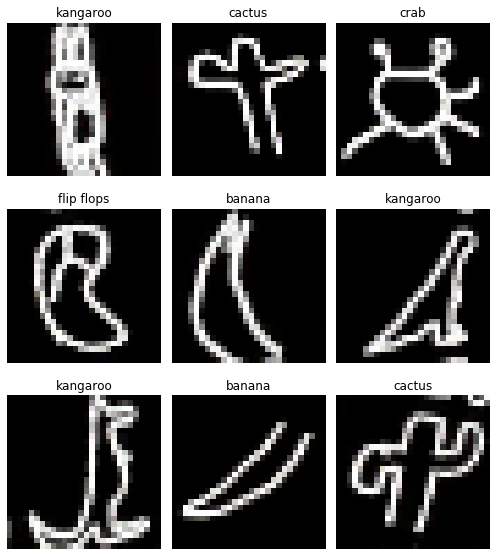

In [17]:
sketch_data.show_batch(rows=3, figsize=(7,8))

In [18]:
learn = cnn_learner(sketch_data, models.resnet34, metrics=error_rate)

In [20]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.762425,0.643073,0.219167,00:17
1,0.757405,0.593227,0.209167,00:16
2,0.723470,0.559972,0.183333,00:16
3,0.665628,0.541063,0.193333,00:16
4,0.634917,0.516674,0.180833,00:16


In [21]:
learn.save('stage-1')

In [22]:
learn.freeze()

In [23]:
learn.unfreeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


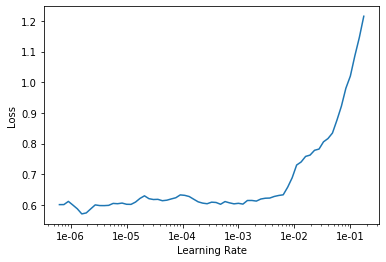

In [25]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(30, max_lr=slice(4e-3,5e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.551679,0.474639,0.151667,00:19
1,0.461697,0.391745,0.129167,00:17
2,0.436365,0.477431,0.151667,00:19
3,0.432133,0.514794,0.174167,00:22
4,0.414255,0.523461,0.172500,00:19
5,0.400405,0.587031,0.190833,00:17
6,0.406135,0.688241,0.215833,00:21
7,0.409965,0.447089,0.132500,00:18
8,0.379688,0.376913,0.120833,00:17
9,0.392108,0.672256,0.214167,00:18


In [27]:
learn.save('stage-2')

In [28]:
interp = ClassificationInterpretation.from_learner(learn)

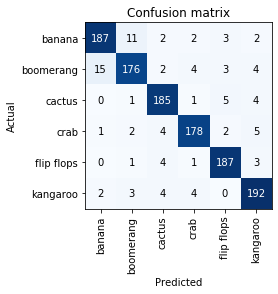

In [29]:
interp.plot_confusion_matrix()

In [34]:
learn.export()

In [18]:
test_df = pd.read_csv(PATH/'sketches_test.csv')

In [85]:
test_df.head

<bound method NDFrame.head of       Unnamed: 0  V1  V2  V3  V4  V5  V6  V7  V8  V9  ...  V777  V778  V779  \
0              1   0   0   0   0   0   0   0   0   0  ...     0     0     0   
1              2   0   0   0   0   0   0   0   0   0  ...     0     0     0   
2              3   0   0   0   0   0   0   0   0   0  ...     0     0     0   
3              4   0   0   0   0   0   0   0   0   0  ...     0     0     0   
4              5   0   0   0   0   0   0   0   0   0  ...     0     0     0   
...          ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   
1195        1196   0   0   0   0   0   0   0   0   0  ...     0     0     0   
1196        1197   0   0   0   0   0   0   0   0   0  ...     0     0     0   
1197        1198   0   0   0   0   0   0   0   0   0  ...     0     0     0   
1198        1199   0   0   0   0   0   0   0   0   0  ...     0     0     0   
1199        1200   0   0   0   0   0   0   0   0   0  ...     0     0     0   

      V780  V781  V78

In [35]:
defaults.device = torch.device('cpu')

pred_class = []
pred_idx = []
outputs = []

for i in range(1200):
    idx = i+1
    img = open_image(str(TEST_PATH)+"/"+str(idx)+".png")
    a,b,c = learn.predict(img)
    pred_class.append(a)
    pred_idx.append(b)
    outputs.append(c)




In [20]:
df = pd.DataFrame(data={"id": range(1,1201,1), "word": pred_class})
df.to_csv("./result_pd.csv", sep=',',index=False)